In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import numpy as np
import math

device = 'cuda'

batch_size = 256

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
#     transforms.RandomRotation(degrees=(-45, 45)),
#     transforms.ColorJitter(brightness=.5,hue=0.5), # 改变图像的亮度和饱和度
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, pin_memory=True, num_workers=4)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size*2,
                                         shuffle=False, pin_memory=True, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


# Res-Net

In [2]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes,
                     kernel_size=3, stride=stride,
                     padding=1, bias=False)
def conv1x1(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes,
                     kernel_size=1, stride=stride, bias=False)

class BasicBlock(nn.Module):
    expansion=1
    def __init__(self, in_planes, out_planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, out_planes, stride)
        self.bn1= nn.BatchNorm2d(out_planes)
        self.relu = nn.ReLU(True) # replace the original value
        self.conv2 = conv3x3(out_planes, out_planes)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.downsample = downsample
        self.stride = stride
    
    def forward(self, x):
        if self.downsample is not None:
            identity = self.downsample(x)
        else:
            identity = x
            
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += identity
        out = self.relu(out)
        return out
    
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_planes, out_planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = conv1x1(in_planes, out_planes)
        self.bn1 = nn.BatchNorm2d(out_planes)
        self.conv2 = conv3x3(out_planes, out_planes, stride)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.conv3 = conv1x1(out_planes, out_planes*self.expansion)
        self.bn3 = nn.BatchNorm2d(out_planes*self.expansion)
        self.relu = nn.ReLU(True)
        self.downsample = downsample
        self.stride = stride
        
    def forward(self, x):
        if self.downsample is not None:
            identity = self.downsample(x)
        else:
            identity = x
            
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        
        out += identity
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=100):
        super().__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, self.in_planes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_planes)
        self.relu = nn.ReLU(True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.make_layer(block, 128, layers[0])
        self.layer2 = self.make_layer(block, 256, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 512, layers[2], stride=2)
        self.layer4 = self.make_layer(block, 1024, layers[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(1024*block.expansion, num_classes)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def make_layer(self, block, out_planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_planes != out_planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.in_planes, out_planes*block.expansion, stride),
                nn.BatchNorm2d(out_planes*block.expansion)
            )
        
        layers = []
        layers.append(block(self.in_planes, out_planes, stride, downsample))
        self.in_planes = out_planes*block.expansion
        for i in range(1, blocks):
            layers.append(block(self.in_planes, out_planes))
            
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out
    
def ResNet18():
    model = ResNet(BasicBlock, [2,2,2,2])
    return model
def ResNet34():
    model = ResNet(BasicBlock, [3,4,6,3])
    return model
def ResNet50():
    model = ResNet(Bottleneck, [3,4,6,3])
    return model

In [3]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(nn.Module):
    def __init__(self, in_channels = 3, num_classes = 100):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True) 
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128)) 
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True) 
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512)) 
        self.conv5 = conv_block(512, 1024, pool=True) 
        self.res3 = nn.Sequential(conv_block(1024, 1024), conv_block(1024, 1024))  
        
        self.classifier = nn.Sequential(nn.MaxPool2d(2), # 1024 x 1 x 1
                                        nn.Flatten(), # 1024 
                                        nn.Linear(1024, num_classes)) # 1024 -> 100
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.res1(out) + out

        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out

        out = self.conv5(out)
        out = self.res3(out) + out
        out = self.classifier(out)
        return out


In [5]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
def adjust_learning_rate(optimizer, current_iter, warmup_iter, max_warm_up_lr=0.1):
    if current_iter <= warmup_iter:
        lr = max_warm_up_lr * current_iter / warmup_iter
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [6]:
loss_arr = []
acc_arr = []
lr_arr = []

def fit(model, epochs, train_loader, valid_loader, optimizer, lr_scheduler,
        loss_fn, updata_lr_every_epoch, warm_up=False, grad_clip=None, PATH='Res2Net.pth'):
    log_interval = int((50000/batch_size)/2)
    for epoch in range(epochs):
        print(f"{'='*20} Epoch: {epoch+1} {'='*20}\n")
        model.train()
        avg_loss = 0
        
        for i, (inputs, targets) in enumerate(train_loader):
            if warm_up == True and epoch < warm_up:
                adjust_learning_rate(optimizer, (i+1)+epoch*len(train_loader), len(trainloader)*warm_up, max_warm_up_lr=0.1)

            outputs = model(inputs.to(device))
            loss = loss_fn(outputs, targets.to(device))
            loss.backward()
            if grad_clip is not None:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            if updata_lr_every_epoch == False:
                sched.step()
                lr_arr.append(get_lr(optimizer))
            optimizer.zero_grad()
            
            avg_loss += loss.item()
            if i % log_interval == log_interval-1:
                print(f"batch: {i+1}, train_loss: {avg_loss/log_interval:.4f}")
        if updata_lr_every_epoch == True:
            sched.step()
            lr_arr.append(get_lr(optimizer))
        
        model.eval()
        correct = 0
        total = 0
        avg_loss = 0
        with torch.no_grad():
            for (images, labels) in valid_loader:
                outputs = model(images.to(device))
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels.to(device)).sum().item()
                total_loss += loss_fn(outputs, labels.to(device))
            loss_arr.append(total_loss.cpu() / len(testloader))
            acc = 100 * correct / total
            acc_arr.append(acc)

        print(f'Accuracy: {acc}% ({correct} / {total}), Loss: {total_loss.cpu() / len(testloader):.3f}, Last_lr: {lr_arr[-1]:.5f}')
    torch.save(model, PATH)

In [8]:
model = ResNet9().to(device)
num_param = sum([param.nelement() for param in model.parameters()])
print("Number of parameter: %.2fM" % (num_param/1e6))

Number of parameter: 30.27M


In [ ]:
epochs = 40
# optimizer = optim.SGD(model.parameters(), lr=max_lr, momentum=0.9, weight_decay=5e-4)
optimizer = optim.Adam(model.parameters(), lr=max_lr, weight_decay=5e-4)
# sched = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 20], gamma=0.2)
sched = optim.lr_scheduler.OneCycleLR(optimizer, 0.001, epochs=epochs,
                                      steps_per_epoch=len(trainloader))


fit(model=model,
    epochs=epochs,
    train_loader=trainloader,
    valid_loader=testloader,
    optimizer=optimizer,
    lr_scheduler=sched,
    loss_fn=nn.CrossEntropyLoss(),
    warm_up=False, grad_clip=None, updata_lr_every_epoch=False, PATH='/ResNet.pth')

Text(0.5, 1.0, 'LR')

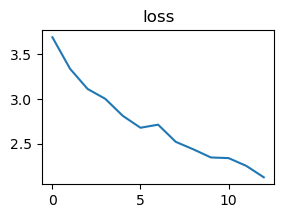

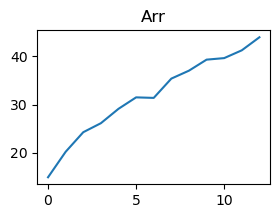

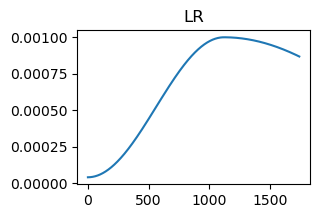

In [8]:
plt.figure(figsize=(3, 2))
plt.plot(loss_arr)
plt.title('loss')

plt.figure(figsize=(3, 2))
plt.plot(acc_arr)
plt.title('Arr')

plt.figure(figsize=(3, 2))
plt.plot(lr_arr)
plt.title('LR')

In [9]:
# PATH = './ResNet.pth'
# torch.save(model.state_dict(), PATH)